In [1]:
!python -m spacy download en_core_web_lg # NEED TO RESTART THE KERNAL AFTER DOWNLOADING

2024-01-28 13:38:49.407959: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-28 13:38:49.408041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-28 13:38:49.411062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-28 13:38:49.427610: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-28 13:38:52.953290: W tensorflow/compiler/tf2

In [2]:
import pandas as pd
from tqdm import tqdm
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy
from nltk.stem.porter import *
import gensim
from gensim import models
from gensim.models import Word2Vec, KeyedVectors

stemmer = PorterStemmer()
nltk.download('stopwords')
nlp = spacy.load('en_core_web_lg')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


***Enter The Relevant Paths***

In [7]:
PATH_EXTERNAL_KNOWLEDGE = 'edges.csv' # other associations that exsitis on other models
USER_STORIES_NAMES = ['supermarket.txt'] # path to the user stories file

# Paris of gold standard relationships;
# NOTE THAT: if there is a class in the gold standard that doesn't have an association,
# you should add a dummy association with that class and edit manually to change the label to 0 in the output of this code.
CURR_PATH = 'supermarket_test.csv'
NAME = 'output.csv' # The output file

In [4]:
df = pd.read_csv(PATH_EXTERNAL_KNOWLEDGE)

entites_calculate = set()
for row in df.iterrows():

  name_1 = row[1]['entity_1']
  name_2 = row[1]['entity_2']

  entites_calculate.add(name_1)
  entites_calculate.add(name_2)

vectors = {}
for entity in tqdm(entites_calculate):
  token = nlp(entity)
  vectors[entity] = token

100%|██████████| 27042/27042 [03:34<00:00, 126.01it/s]


# Run the following cells

# Built Similarity Model

In [8]:
entites_calculate = set()
dff = pd.read_csv(CURR_PATH)
for row in dff.iterrows():

  name_1 = row[1]['x']
  name_2 = row[1]['y']

  entites_calculate.add(name_1.lower())
  entites_calculate.add(name_2.lower())

i = 0
for entity in entites_calculate:
  print(entity)
  i = i + 1
  token = nlp(entity)
  vectors[entity] = token

recipe
store
shopping list
wishlist
order
customer
personal discount
newsletter
product
loyalty card
delivery service


In [9]:
classes = set()
dictonery = {}
relationships = set()
df = pd.read_csv(CURR_PATH)
for row in df.iterrows():
  if row[1][0].lower() == 'estimator' or row[1][0].lower() == 'publisher' :
    name_1 = row[1][0].lower()
  else:
    name_1 = stemmer.stem(row[1][0].lower())

  if row[1][1].lower() == 'estimator' or row[1][1].lower() == 'publisher':
    name_2 = row[1][1].lower()
  else:
    name_2 = stemmer.stem(row[1][1].lower())
  if name_1 not in dictonery.keys():
    dictonery[name_1] = row[1][0].lower()
  if name_2 not in dictonery.keys():
    dictonery[name_2] = row[1][1].lower()
  classes.add(name_1)
  classes.add(name_2)

  if (name_1,name_2) not in relationships and (name_2,name_1) not in relationships :
      relationships.add((name_1,name_2))

nodes = list(classes)
relationships = list(relationships)

In [10]:
actors = set()
actors.add('estimator')
actions = set()
benefits = set()
prev_sim = set()

class_noun = {}
for cll in classes:
  class_noun[cll] = set()
subjects_objects = set()
objects_subjects = set ()

object_object = set()
subjects_subjects = set()

or_and_exsistance = set()

tranverb = {}

def usToWords(row):
    objects = set()
    subjects = set()
    tran_flag = 0
    text = row
    filtered_sentence = []
    # stop_words = set(stopwords.words('english'))
    text = text.lower()
    TAG_RE = re.compile(r'<[^>]+>')
    text = TAG_RE.sub('', text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r"([!@#$?><+\-:;0-9'~_=%^&*()/.\",\)\(\\\}\{\[\]])", r"", text)
    set_of_tokens = nlp(text)
    classes_list = []

    nouns = []
    compund_noun = ''
    skip = 0
    verbos = 0
    and_or_counter = 0
    for i, word in enumerate(set_of_tokens):
        if skip > 0:
          skip = skip - 1
          continue

        dep_1 = word.dep_
        noun = word.tag_
        if noun == 'NN' and len(word.text) > 2:
          nouns.append(stemmer.stem(word.text).lower())
        dep_2 = ''
        dep_3 = ''
        word = word.text

        word_1 = word.lower()
        word_2 = ''
        word_3 = ''

        if len(set_of_tokens) > i + 1:
          dep_2 = set_of_tokens[i + 1].dep_
          word_2 = word_1 + ' ' + set_of_tokens[i + 1].text
          word_2 = stemmer.stem(word_2).lower()

        if len(set_of_tokens) > i + 2:
          dep_3 = set_of_tokens[i + 2].dep_
          word_3 = word_1 + ' ' + set_of_tokens[i + 1].text + ' ' + set_of_tokens[i + 2].text
          word_3 = stemmer.stem(word_3).lower()

        if word_2 == 'want to':
          # print(word_2)
          verbos = 1

        if word_2 == 'so that':
          # print(word_2)
          verbos = 2
        word_5 = stemmer.stem(word_1)
        if word_3 in classes:
          if dep_1 == 'dobj' or dep_2 == 'dobj' or dep_3 == 'dobj':
            objects.add(word_3)
          if dep_1 == 'nsubj' or dep_2 == 'nsubj' or dep_3 == 'nsubj':
            subjects.add(word_3)

          filtered_sentence.append(word_3)
          skip = 2
          if verbos == 1:
            actions.add(word_3)
          if verbos == 0:
            actors.add(word_3)
          if verbos == 2:
            benefits.add(word_3)

          classes_list.append(word_3)

        elif word_2 in classes:
          if dep_1 == 'dobj' or dep_2 == 'dobj' or dep_3 == 'dobj':
            objects.add(word_2)
          if dep_1 == 'nsubj' or dep_2 == 'nsubj' or dep_3 == 'nsubj':
            subjects.add(word_2)

          filtered_sentence.append(word_2)
          skip = 1

          if verbos == 1:
            actions.add(word_2)
          if verbos == 0:
            actors.add(word_2)
          if verbos == 2:
            benefits.add(word_2)

          classes_list.append(word_2)

        else:
          if word_5 in classes:
            if dep_1 == 'dobj' or dep_2 == 'dobj' or dep_3 == 'dobj':
              objects.add(word_5)

            if dep_1 == 'nsubj' or dep_2 == 'nsubj' or dep_3 == 'nsubj':
              subjects.add(word_5)

            if verbos == 1:
              actions.add(word_5)
            if verbos == 0:
              actors.add(word_5)
            if verbos == 2:
              benefits.add(word_5)

            classes_list.append(word_5)

          if len(word_1) != 0:

            if word_1 != 'estimator' and word_1 != 'publisher':
              filtered_sentence.append(stemmer.stem(word_1))
            else:
              filtered_sentence.append(word_1)



    for i in range(len(classes_list)):
      for j in range(len(classes_list)):
        try:
          s = re.search(r''+classes_list[i]+'(.*?)'+classes_list[j]+'', row).group(1)
          if 'and' in s or 'or' in s:
            flag = True
            for class_i in classes:
              if class_i != classes_list[i] and class_i != classes_list[j] and class_i in s:
                flag = False
            if flag:
              or_and_exsistance.add((classes_list[i], classes_list[j]))
        except:
          continue
    for cl in classes_list:
      for no in nouns:
        class_noun[cl].add(no)


    for i in range(len(objects)):
      for j in range(len(subjects)):
        objects_subjects.add((list(objects)[i], list(subjects)[j]))

    for i in range(len(objects)):
      for j in range(len(objects)):
        object_object.add((list(objects)[i], list(objects)[j]))

    for i in range(len(subjects)):
      for j in range(len(subjects)):
        object_object.add((list(subjects)[i], list(subjects)[j]))

    return filtered_sentence

documents = []
i = 0
for name in USER_STORIES_NAMES:
  with open(name,encoding='cp1252') as f:
      lines = f.readlines()
  for line in lines:
    parsed = usToWords(line)
    documents.append(usToWords(line))
try:
  actors.remove('estim')
except:
  print('dd')

dd


In [11]:
us_model = gensim.models.Word2Vec(vector_size=300, window=5, min_count=1, sg=1)
us_model.build_vocab(documents)

print("starting to train")
us_model.train(documents, total_examples=len(documents), epochs=1)
print("finished")

word_vectors_us = us_model.wv

wanted_words_us = []
wanted_words_se = []

count = 0
for word in word_vectors_us.index_to_key:
    if word in classes:
        wanted_words_us.append(word)
        count += 1

wanted_vocab_us = dict((k, word_vectors_us.index_to_key) for k in wanted_words_us if k in word_vectors_us.index_to_key)

starting to train
finished


# Build Data

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

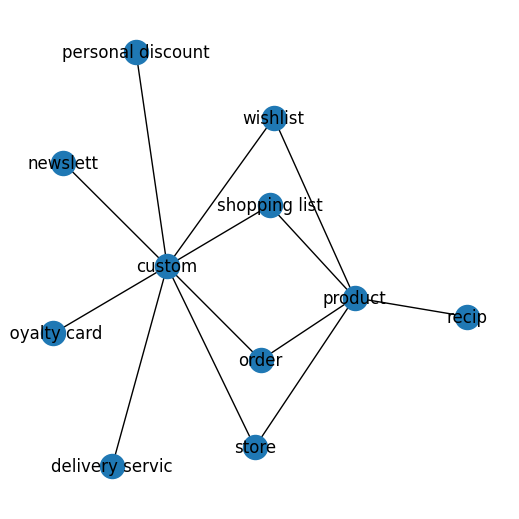

In [19]:
nxGraph = nx.Graph()
nodes = list(dict.fromkeys(nodes))


nxGraph.add_nodes_from(n for n in nodes)
nxGraph.add_edges_from([(e[0],e[1]) for e in relationships])

plt.figure(figsize=(5,5))
nx.draw_kamada_kawai(nxGraph, with_labels=True)

nodes = []
for item in classes:
  nodes.append(item.lower())

exsitsing_rel = list(dict.fromkeys(relationships))

select_links = set()

for n_1 in nodes:
  # if n_1 == 'estimation':
  #   continue
  for n_2 in nodes:
    if n_1 == n_2 or (n_1,n_2) in exsitsing_rel or (n_2,n_1) in exsitsing_rel:
      continue
    else:
       select_links.add((n_1,n_2))

not_exsits = list(select_links)
not_exsitsing_rel = list(dict.fromkeys(not_exsits))

In [20]:

def find_friends_of_friends(g, v):
    "Returns a set with all the friends of friends of v that are not friends of v"
    friends_set = set(g.neighbors(v))
    friends_of_friends_set = set()
    for f in friends_set:
        friends_of_friends_set |= set(g.neighbors(f))
    friends_of_friends_set -= friends_set
    friends_of_friends_set -= {v}
    return friends_of_friends_set


def rank_friends_of_friends(g, v):
    rank_dict = {}
    vertices_set = find_friends_of_friends(g, v)
    for u in vertices_set:
        rank_dict[u] = len(common_friends(g, v, u))
    sorted_d = sorted(rank_dict.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_d

def common_friends(g,u,v):
  if not g.has_node(u) or not g.has_node(v):
      return None
  return set(g.neighbors(u)) & set(g.neighbors(v))

In [21]:
from tqdm import tqdm_notebook as tqdm

def friends_measure(g, u,v):
    s = 0
    for x in find_friends_of_friends(g,u):
        for y in find_friends_of_friends(g,v):
            if g.has_edge(x,y) or x == y:
                s += 1
    return s

def total_friends(g, u, v):
    return len(set(g.neighbors(v)) | set(g.neighbors(u)))

def get_features_dict(g,u, v):
    removed_edge = False
    if g.has_edge(u,v):
        g.remove_edge(u,v) #  remove edge before feature calculation
        removed_edge = True
    try:
        d = {
            'degree_v': len(list(g.neighbors(v))),
            'degree_u': len(list(g.neighbors(u))),
            'total_friends': total_friends(g,u,v),
            'common_friends': len(common_friends(g,u,v)),
            'jaccard_coefficient': list(nx.jaccard_coefficient(g,[(u,v)]))[0][2],
            'adamic_adar_index': list(nx.adamic_adar_index(g,[(u,v)]))[0][2],
            'friends_measure': friends_measure(g, u,v)
        }
    except:
        if removed_edge:
            g.add_edge(u,v) # return the edge back to the graph
        return None


    if removed_edge:
        g.add_edge(u,v) # return the edge back to the graph
    return d

In [22]:
def calculate_most_similart(name_1, name_2):
  data = {'tuple': [], 'sim': []}
  df = pd.read_csv(PATH_EXTERNAL_KNOWLEDGE)
  i = 0
  info = []
  for row in df.iterrows():

    token1 = vectors[row[1]['entity_1']]
    token2 = vectors[row[1]['entity_2']]

    sim_1 = token1.similarity(vectors[name_1])
    sim_2 = token2.similarity(vectors[name_2])

    info.append(((sim_1 + sim_2)/2, (row[1]['entity_1'],row[1]['entity_2'] )))

  sorted_by_second = sorted(info, key=lambda tup: tup[0])
  sorted_by_second.reverse()
  sorted_by_second[0]

  return sorted_by_second, sorted_by_second

In [ ]:
data = {'name_a': [], 'name_b': [], 'most_similar_1': [], 'most_similar_2': [], 'most_similar_3': [], 'similarity_prev_1': [], 'target': [], 'appear_a': [],
        'apepar_b': [],  'similarity_b': [],
        'both': [], 'sum': [], 'actor_a': [], 'actor_b': [], 'window_3': [], 'window_5': [],
        'action_a': [], 'action_b': [],
        'benefit_a': [], 'benefit_b' : [],
        'sub_obj' : [], 'obj_sub': [],
        'obj_obj' : [], 'sub_sub': [],
        'and_or_btw': [], 'common_firends': [],
        'both_a' : [], 'both_b': [], 'both_a_b': [],
        'sim_a_prev_1': [], 'sim_b_prev_1': [],
        'sim_a_prev_2': [], 'sim_b_prev_2': [],
        'sim_a_prev_3': [], 'sim_b_prev_3': [],
        'similarity_prev_2': [], 'similarity_prev_3': [],
        'sim_avg_3_rel': []}

k = 0
already_visited = []
for rel in exsitsing_rel:
  print(f'rel {k} out of {len(exsitsing_rel)+len(not_exsitsing_rel)}')
  k = k + 1
  if (rel[0], rel[1]) in already_visited or (rel[1], rel[0]) in already_visited:
    continue
  else:
    already_visited.append((rel[0], rel[1]))
  rele = [(rel[0],rel[1])]
  for rel in rele:
    data['name_a'].append(rel[0])
    data['name_b'].append(rel[1])


    token_1 = nlp(dictonery[rel[0]])
    token_2 = nlp(dictonery[rel[1]])
    data['similarity_b'].append(token_1.similarity(token_2))

    for i,rels in enumerate([rel[0], rel[1]]):
      if i == 0:
        col = '_a'
      else:
        col = '_b'

      if rels in actors:
        data[f'actor{col}'].append(1)
      else:
        data[f'actor{col}'].append(0)

      if rels in actions:
        data[f'action{col}'].append(1)
      else:
        data[f'action{col}'].append(0)

      if rels in benefits:
        data[f'benefit{col}'].append(1)
      else:
        data[f'benefit{col}'].append(0)

    if (rel[0], rel[1]) in subjects_objects:
      data['sub_obj'].append(1)
    else:
      data['sub_obj'].append(0)

    if (rel[1], rel[0]) in objects_subjects:
      data['obj_sub'].append(1)
    else:
      data['obj_sub'].append(0)

    if (rel[1], rel[0]) in object_object or (rel[0], rel[1]) in object_object:
      data['obj_obj'].append(1)
    else:
      data['obj_obj'].append(0)

    if (rel[1], rel[0]) in subjects_subjects or (rel[0], rel[1]) in subjects_subjects:
      data['sub_sub'].append(1)
    else:
      data['sub_sub'].append(0)

    if (rel[1], rel[0]) in or_and_exsistance or (rel[0], rel[1]) in or_and_exsistance:
      data['and_or_btw'].append(1)
    else:
      data['and_or_btw'].append(0)

    s1 = class_noun[rel[1]]
    s2 = class_noun[rel[0]]
    data['common_firends'].append(len(set.intersection(s1, s2)))

    tupe, sim = calculate_most_similart(dictonery[rel[0]], dictonery[rel[1]])
    data['most_similar_1'].append(tupe[0][1])
    data['most_similar_2'].append(sim[1][1])
    data['most_similar_3'].append(sim[2][1])

    token1_1 = vectors[tupe[0][1][0]]
    token2_1 = vectors[tupe[0][1][1]]

    token1_2 = vectors[tupe[1][1][0]]
    token2_2 = vectors[tupe[1][1][1]]

    token1_3 = vectors[tupe[2][1][0]]
    token2_3 = vectors[tupe[2][1][1]]


    data['sim_a_prev_1'].append(token1_1.similarity(vectors[dictonery[rel[0]]]))
    data['sim_b_prev_1'].append(token2_1.similarity(vectors[dictonery[rel[1]]]))

    data['sim_a_prev_2'].append(token1_2.similarity(vectors[dictonery[rel[0]]]))
    data['sim_b_prev_2'].append(token2_2.similarity(vectors[dictonery[rel[1]]]))

    data['sim_a_prev_3'].append(token1_3.similarity(vectors[dictonery[rel[0]]]))
    data['sim_b_prev_3'].append(token2_3.similarity(vectors[dictonery[rel[1]]]))

    data['similarity_prev_1'].append(sim[0][0])
    data['similarity_prev_2'].append(sim[1][0])
    data['similarity_prev_3'].append(sim[2][0])

    data['sim_avg_3_rel'].append((sim[0][0]+sim[1][0]+sim[2][0])/3)

    appear_a = 0
    appear_b = 0
    both = 0
    window_3 = 0
    window_5 = 0
    for us in documents:
      temp = []
      for word in us:
        word = stemmer.stem(word)
        temp.append(word)

      word_1 = stemmer.stem(rel[0])
      word_2 = stemmer.stem(rel[1])


      if word_1 in temp:
        appear_a = appear_a + 1

      if word_2 in temp:
        appear_b = appear_b + 1

      if word_1 in temp and word_2 in temp:
        both = both + 1
        temp.append('<>')
        temp.append('<>')
        temp.append('<>')
        temp.append('<>')
        temp.append('<>')
        for index, word in enumerate(temp):
          if word == '<>':
            break
          if word_1 == word:

            if word_2 == temp[index+1] or word_2 == temp[index+2] or word_2 == temp[index+3]:
              window_3 = window_3 + 1
              window_5 = window_5 + 1

            elif word_2 == temp[index+4] or  word_2 == temp[index+5]:
              window_5 = window_5 + 1

          elif word_2 == word:

            if word_1 == temp[index+1] or word_1 == temp[index+2] or word_1 == temp[index+3]:
              window_3 = window_3 + 1
              window_5 = window_5 + 1

            elif word_1 == temp[index+4] or  word_1 == temp[index+5]:
              window_5 = window_5 + 1


    data['window_3'].append(window_3)
    data['window_5'].append(window_5)

    if appear_a == 0:
      appear_a = 1
    if appear_b == 0:
      appear_a = 1
    data['appear_a'].append(appear_a / len(documents))
    data['apepar_b'].append(appear_b / len(documents))
    data['both'].append(both / len(documents))
    data['both_a'].append(both / appear_a)
    data['both_b'].append(both / appear_b)
    data['both_a_b'].append(both / ((appear_a+appear_b) - both))
    data['sum'].append((appear_a + appear_b) / len(documents))
    data['target'].append(1)



for rel in not_exsitsing_rel:
  print(f'rel {k} out of {len(exsitsing_rel)+len(not_exsitsing_rel)}')
  k = k + 1
  if (rel[0], rel[1]) in already_visited or (rel[1], rel[0]) in already_visited:
    continue
  else:
    already_visited.append((rel[0], rel[1]))
  rele = [(rel[0],rel[1])]
  for rel in rele:
    if rel[0] == 'estimation' or rel[1] == 'estimation':
      continue
    for i,rels in enumerate([rel[0], rel[1]]):
      if i == 0:
        col = '_a'
      else:
        col = '_b'

      if rels in actors:
        data[f'actor{col}'].append(1)
      else:
        data[f'actor{col}'].append(0)

      if rels in actions:
        data[f'action{col}'].append(1)
      else:
        data[f'action{col}'].append(0)

      if rels in benefits:
        data[f'benefit{col}'].append(1)
      else:
        data[f'benefit{col}'].append(0)



    data['name_a'].append(rel[0])
    data['name_b'].append(rel[1])
    # data['similarity_a'].append(us_model.wv.similarity(rel[0], rel[1]))

    token_1 = nlp(dictonery[rel[0]])
    token_2 = nlp(dictonery[rel[1]])
    data['similarity_b'].append(token_1.similarity(token_2))

    if (rel[0], rel[1]) in subjects_objects:
      data['sub_obj'].append(1)
    else:
      data['sub_obj'].append(0)

    if (rel[1], rel[0]) in objects_subjects:
      data['obj_sub'].append(1)
    else:
      data['obj_sub'].append(0)

    if (rel[1], rel[0]) in object_object or (rel[0], rel[1]) in object_object:
      data['obj_obj'].append(1)
    else:
      data['obj_obj'].append(0)

    if (rel[1], rel[0]) in subjects_subjects or (rel[0], rel[1]) in subjects_subjects:
      data['sub_sub'].append(1)
    else:
      data['sub_sub'].append(0)

    if (rel[1], rel[0]) in or_and_exsistance or (rel[0], rel[1]) in or_and_exsistance:
      data['and_or_btw'].append(1)
    else:
      data['and_or_btw'].append(0)

    s1 = class_noun[rel[1]]
    s2 = class_noun[rel[0]]
    data['common_firends'].append(len(set.intersection(s1, s2)))

    appear_a = 0
    appear_b = 0
    both = 0
    window_3 = 0
    window_5 = 0
    for us in documents:
      temp = []
      for word in us:
        word = stemmer.stem(word)
        temp.append(word)

      word_1 = stemmer.stem(rel[0])
      word_2 = stemmer.stem(rel[1])

      if word_1 in temp:
        appear_a = appear_a + 1

      if word_2 in temp:
        appear_b = appear_b + 1

      if word_1 in temp and word_2 in temp:
        both = both + 1
        temp.append('<>')
        temp.append('<>')
        temp.append('<>')
        temp.append('<>')
        temp.append('<>')
        for index, word in enumerate(temp):
          if word == '<>':
            break
          if word_1 == word:

            if word_2 == temp[index+1] or word_2 == temp[index+2] or word_2 == temp[index+3]:
              window_3 = window_3 + 1
              window_5 = window_5 + 1

            elif word_2 == temp[index+4] or  word_2 == temp[index+5]:
              window_5 = window_5 + 1

          elif word_2 == word:

            if word_1 == temp[index+1] or word_1 == temp[index+2] or word_1 == temp[index+3]:
              window_3 = window_3 + 1
              window_5 = window_5 + 1

            elif word_1 == temp[index+4] or  word_1 == temp[index+5]:
              window_5 = window_5 + 1


    tupe, sim = calculate_most_similart(dictonery[rel[0]], dictonery[rel[1]])
    data['most_similar_1'].append(tupe[0][1])
    data['most_similar_2'].append(sim[1][1])
    data['most_similar_3'].append(sim[2][1])

    token1_1 = vectors[tupe[0][1][0]]
    token2_1 = vectors[tupe[0][1][1]]

    token1_2 = vectors[tupe[1][1][0]]
    token2_2 = vectors[tupe[1][1][1]]

    token1_3 = vectors[tupe[2][1][0]]
    token2_3 = vectors[tupe[2][1][1]]

    data['sim_a_prev_1'].append(token1_1.similarity(vectors[dictonery[rel[0]]]))
    data['sim_b_prev_1'].append(token2_1.similarity(vectors[dictonery[rel[1]]]))

    data['sim_a_prev_2'].append(token1_2.similarity(vectors[dictonery[rel[0]]]))
    data['sim_b_prev_2'].append(token2_2.similarity(vectors[dictonery[rel[1]]]))

    data['sim_a_prev_3'].append(token1_3.similarity(vectors[dictonery[rel[0]]]))
    data['sim_b_prev_3'].append(token2_3.similarity(vectors[dictonery[rel[1]]]))

    data['similarity_prev_1'].append(sim[0][0])
    data['similarity_prev_2'].append(sim[1][0])
    data['similarity_prev_3'].append(sim[2][0])

    data['sim_avg_3_rel'].append((sim[0][0]+sim[1][0]+sim[2][0])/3)

    data['window_3'].append(window_3)
    data['window_5'].append(window_5)
    if appear_a == 0:
      appear_a = 1
    if appear_b == 0:
      appear_b = 1
    data['appear_a'].append(appear_a / len(documents))
    data['apepar_b'].append(appear_b / len(documents))
    data['both'].append(both / len(documents))
    data['both_a'].append(both / appear_a)
    data['both_b'].append(both / appear_b)
    data['both_a_b'].append(both / ((appear_a+appear_b) - both))
    data['sum'].append((appear_a + appear_b)/ len(documents))
    data['target'].append(0)


df = pd.DataFrame(data)

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df["window_5"] = min_max_scaler.fit_transform(df[["window_5"]])
df["window_3"] = min_max_scaler.fit_transform(df[["window_3"]])
df.to_csv(NAME)